<a href="https://colab.research.google.com/github/ThePingPing/Torch_Model/blob/main/GansMinstMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [410]:
## importation Libs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import sys

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from torch.optim import Adam, SGD

from sklearn.model_selection import train_test_split

import sklearn.metrics as skm

import time

import copy

In [411]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  38567 KiB |  93592 KiB |  14362 GiB |  14362 GiB |\n|       from large pool |  16640 KiB |  47382 KiB |      0 GiB |      0 GiB |\n|       from small pool |  21927 KiB |  53514 KiB |  14362 GiB |  14362 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  38567 KiB |  93592 KiB |  14362 GiB |  14362 GiB |\n|       from large pool |  16640 KiB |  47382 KiB |

In [412]:
## Constant Initialize
numbers_epochs = 50000
batch_size = 100

In [413]:
## Create Discriminator Dis Model Intance

def CreateTheDiscriminator(printtoggle=False):

    class discriminatorNet(nn.Module):

        def __init__(self, printtoggle):
            super().__init__()

            """ for the Toggle """
            self.print = printtoggle

            ### ----------- Model Structure Only Linear ------------ ###


            ### -------------- Linear Layers ------------ ###

            size_image = 28*28

            self.linear1 = nn.Linear(size_image, 256)
            self.linear2 = nn.Linear(256, 256)
            self.linear3 = nn.Linear(256, 1) ## That a gans So only 1 output coz the Classification is True or False

        def forward(self, x):

            if self.print: print(f'Input:{list(x.shape)}')

            ## ------- to Linear Layers --------- ##

            x = F.leaky_relu(self.linear1(x))
            x = F.leaky_relu(self.linear2(x))
            x = self.linear3(x)

            if self.print: print(f' After the linear Block from discriminatorNet  :{list(x.shape)}')

            return torch.sigmoid(x)

    DiscriminatorMnist = discriminatorNet(printtoggle)

    return DiscriminatorMnist


In [414]:
# Create Generator Model Intance

def CreateTheGenerator(printtoggle=False):

    class generatorNet(nn.Module):

        def __init__(self, printtoggle):
            super().__init__()

            """ for the Toggle """
            self.print = printtoggle

            ### ----------- Model Structure Only Linear ------------ ###


            ### -------------- Linear Layers ------------ ###

            input_size = 64

            self.linear1 = nn.Linear(input_size, 256)
            self.linear2 = nn.Linear(256, 256)
            self.linear3 = nn.Linear(256, 784) ## The input Size comming From the the Discriminator

        def forward(self, x):

            if self.print: print(f'Input:{list(x.shape)}')

            ## ------- to Linear Layers --------- ##

            x = F.leaky_relu(self.linear1(x))
            x = F.leaky_relu(self.linear2(x))
            x = self.linear3(x)

            if self.print: print(f' After the linear Block from generatorNet :{list(x.shape)}')

            return torch.tanh(x)

    GeneratorMnist = generatorNet(printtoggle)
    return GeneratorMnist



In [415]:
def create_image_data_mnist():

    data_mnist = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')
    data_mnist = data_mnist[ :, 1: ]


    ## After read documentation normalize the data between [-1 ,1]
    data_mnist_normal = data_mnist / np.max(data_mnist) ## from [0 , 250] --> to [0, 1]
    data_mnist_normal = 2*data_mnist_normal -1 ## from [0 , 2] --> to [-1 , 1]

    ## now covert to tensort

    data_mnist_tensor = torch.tensor(data_mnist_normal).float()
    return data_mnist_tensor

In [416]:
data_mnist_tensor = create_image_data_mnist()

In [417]:
## Discriminator Initiliaze

def initialize_discriminator_model():

    DiscriModelmnist = CreateTheDiscriminator(False)
    learning_rate = (3 * (10 ** -4)) ## choice a factor between [-3 to - 4] coz if not that's not give a good result
    DiscriOptimizer = Adam(DiscriModelmnist.parameters(), lr=learning_rate)

    return DiscriModelmnist, DiscriOptimizer

In [418]:
## Generator Initiliaze

def initialize_generator_model():

    GenModelmnist = CreateTheGenerator(False)
    learning_rate = (3 * (10 ** -4))
    GenOptimizer = Adam(GenModelmnist.parameters(), lr=learning_rate)

    return GenModelmnist, GenOptimizer

In [419]:
 ## choice Loss Function for the model

def choice_loss():
  loss_function = nn.BCELoss() ## Binary Classification task

  return loss_function

In [420]:
## Call the fonction and take your model Instance

DiscriModelmnist, DiscriOptimizer = initialize_discriminator_model()
GenModelmnist, GenOptimizer = initialize_generator_model()
loss_function = choice_loss()



In [421]:
def train_model(DiscriModelmnist, DiscriOptimizer, GenModelmnist, GenOptimizer, loss_function ,data_mnist_tensor, numbers_epochs, batch_size):

  ## Implement a new model , never see any data
  start_time = time.time()

  ## Push to GPU
  D_Model = DiscriModelmnist.to(device)
  G_Model = GenModelmnist.to(device)

  ## initialize losses / Descision Discriminator

  discrminator_losses = np.zeros((numbers_epochs, 2))
  discrminator_choice = np.zeros((numbers_epochs, 2))

  ## loop over epochs
  for epochi in range(numbers_epochs):
    # loop over the epochs and create the minibatches of REAL and FAKE

    random_idx = torch.randint(data_mnist_tensor.shape[0], (batch_size, ))
    real_images = data_mnist_tensor[random_idx, :].to(device)
    fake_images = G_Model(torch.randn(batch_size, 64).to(device)) # output Generator

    ## initialize the labels for the REAL and FAKE images
    real_label = torch.ones(batch_size, 1).to(device)
    fake_label = torch.zeros(batch_size, 1).to(device)

    ### ------------ Train the Discrimanator --------- ###

    """ In Forward Pass the loss from the Real image """

    D_Yhat_real = D_Model(real_images) ## Real image into the Discrimination
    # print("form D_Yhat_real Shape ", D_Yhat_real.shape , "from real_label shape : ", real_label.shape)
    D_loss_real = loss_function(D_Yhat_real, real_label) ## all label true == 1

    D_Yhat_fake = D_Model(fake_images) ## Fake image into the Discrimination
    D_loss_fake = loss_function(D_Yhat_fake, fake_label) ## all label true == 0


    """ Combine the Loss from the both """

    D_loss = D_loss_real + D_loss_fake
    discrminator_losses[epochi, 0] = D_loss.item()
    discrminator_choice[epochi, 0] = torch.mean((D_Yhat_real > 0.5).float()).detach()

    """ In Backprop the loss from the Real image """
    DiscriOptimizer.zero_grad()
    D_loss.backward()
    DiscriOptimizer.step()

    ### --------------- Train the Generator -------------- ###

    fake_images = G_Model(torch.randn(batch_size, 64).to(device))
    D_Yhat_fake = D_Model(fake_images)


    """ Collect and Computing Loss & Accuracy  """

    G_loss = loss_function(D_Yhat_fake, real_label)
    discrminator_losses[epochi, 1] = G_loss.item()
    discrminator_choice[epochi, 1] = torch.mean((D_Yhat_fake > 0.5).float()).detach()

    """ In Backprop """

    GenOptimizer.zero_grad()
    G_loss.backward()
    GenOptimizer.step()


    ## Print Status Message

    if(epochi + 1) % 500 == 0:
      mgs = f'Finished the epoch {epochi +1} / {numbers_epochs} '
      sys.stdout.write('\r' + mgs)

  ## Check Time Machine

  G_ModelTrained = G_Model
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("The time computing for the Model training / retrainig is --> ", int(elapsed_time / 60) ," min ," , int(elapsed_time % 60), " sec"  )

  return G_ModelTrained, discrminator_losses, discrminator_choice


In [422]:
G_ModelTrained, losses, choices = train_model(DiscriModelmnist, DiscriOptimizer, GenModelmnist, GenOptimizer, loss_function ,data_mnist_tensor, numbers_epochs, batch_size)

Finished the epoch 50000 / 50000 The time computing for the Model training / retrainig is -->  4  min , 26  sec


In [423]:
def plot_train_result(losses, choices):

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))

    ax[0].plot(losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Model Losses ')
    ax[0].legend(['Discriminator', 'Generator'])
    # ax[0].set_xlim([4000, 6000])

    ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=0.1)
    ax[1].set_xlabel('Discriminator loss')
    ax[1].set_ylabel('Generator loss')


    ax[2].plot(choices)
    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('Probability for Real')

    ax[2].set_title('Discriminator Output')
    ax[2].legend(['Real', 'Fake'])
    plt.show()

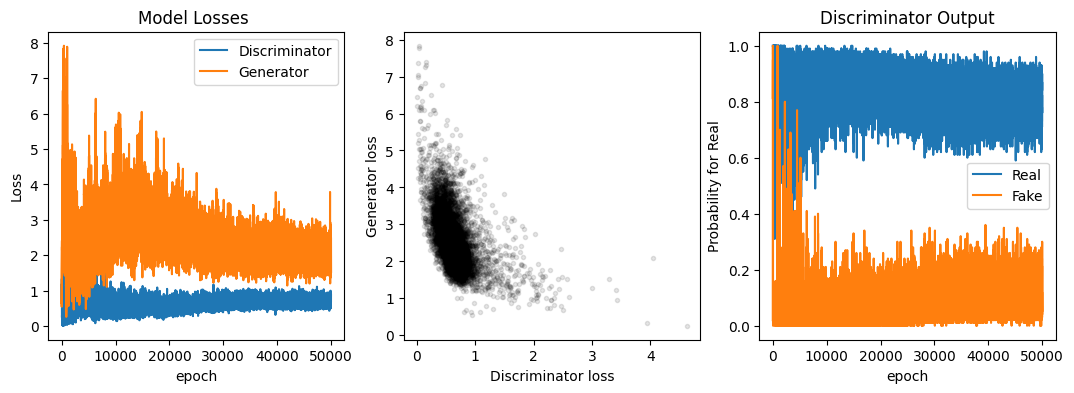

In [424]:
plot_train_result(losses, choices)

In [425]:
## Generate the image used the generator
def generate_image():
  G_ModelTrained.eval()
  fake_image_gen = G_ModelTrained(torch.randn(12,64).to(device)).cpu()

  fig, axs = plt.subplots(3, 4, figsize=(8,6))
  for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_image_gen[i, :, ].detach().view(28,28), cmap = 'gray')
    ax.axis('off')

  plt.show()

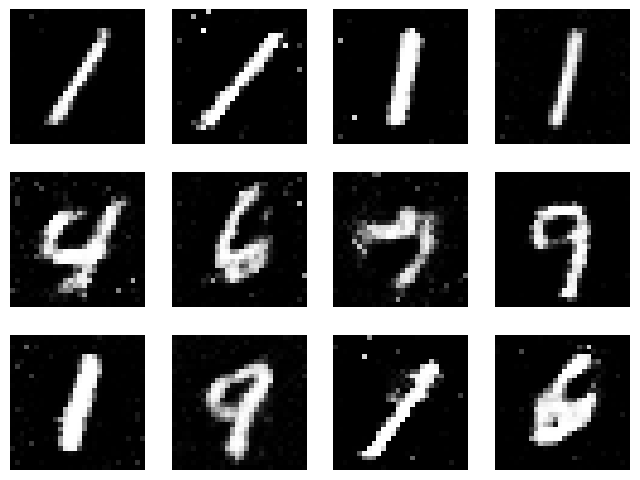

In [426]:
generate_image()